In [1]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset

raw_datasets = load_dataset("yangezheng/tum-nlp-sexism-socialmedia-balanced")

raw_datasets = raw_datasets.filter(lambda x: x['text'] != None)
raw_datasets = raw_datasets.filter(lambda x: len(x['text']) <= 500)

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(row):
    return tokenizer(row["text"], truncation=True)

# apply tokenizer to dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# collation
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [2]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label_sexist'],
        num_rows: 16274
    })
    validation: Dataset({
        features: ['text', 'label_sexist'],
        num_rows: 1810
    })
    test: Dataset({
        features: ['text', 'label_sexist'],
        num_rows: 2008
    })
})

### Statistic 

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize

def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)


df = pd.DataFrame(raw_datasets['train'])
print(df.head())

                                                text  label_sexist
0  ITALY - RAPE JIHAD days after horrific gang-ra...             0
1  I dont take you places because I wanna be frie...             1
2  [USER] This is actually the most worrying bit ...             1
3  You mother fucking piece of trash stupid fucki...             1
4         Yes, this will certainly bring down Trump.             0


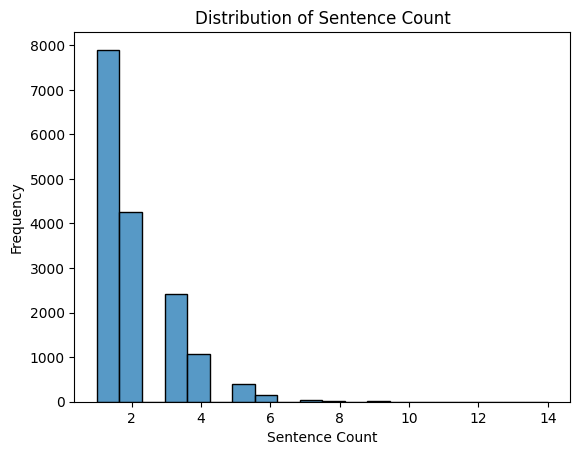

In [4]:
df['sentence_count'] = df['text'].apply(count_sentences)
sns.histplot(df['sentence_count'], bins = 20)
plt.title("Distribution of Sentence Count")
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")
plt.show()

In [5]:
# filter out rows with more than 3 sentence
df = df[df['sentence_count'] <= 3]
df.head()

,text,label_sexist,sentence_count
0,ITALY - RAPE JIHAD days after horrific gang-ra...,0,2
1,I dont take you places because I wanna be frie...,1,1
2,[USER] This is actually the most worrying bit ...,1,3
3,You mother fucking piece of trash stupid fucki...,1,1
4,"Yes, this will certainly bring down Trump.",0,1


In [6]:
df

,text,label_sexist,sentence_count
0,ITALY - RAPE JIHAD days after horrific gang-ra...,0,2
1,I dont take you places because I wanna be frie...,1,1
2,[USER] This is actually the most worrying bit ...,1,3
3,You mother fucking piece of trash stupid fucki...,1,1
4,"Yes, this will certainly bring down Trump.",0,1
...,...,...,...
16269,WTF? Good to know the Nation has this Green LO...,0,2
16270,[USER] Breaking news: women have to suck the D...,1,1
16271,"Whether or not you agree, feminism is about me...",1,2
16272,The application of successfully completing the...,1,1


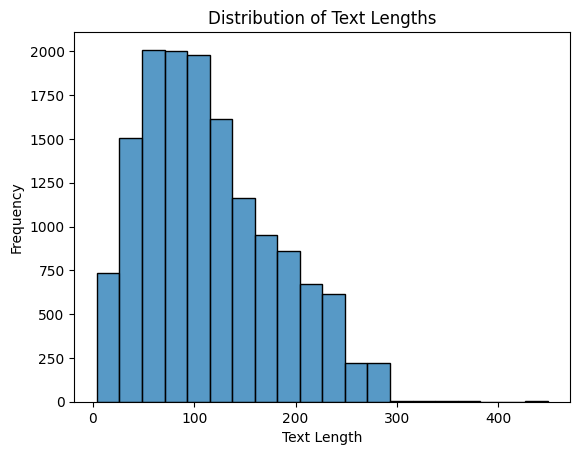

In [61]:
df['text_length'] = df['text'].apply(len)
sns.histplot(df['text_length'], bins = 20)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [62]:
df = df[df['text_length'] < 300]
df = df[df['text_length'] > 200]


In [45]:
df

,text,label_sexist,sentence_count,text_length
27,"I am so sick to look those pussies, the child ...",1,2,311
1150,Judge Kavanaugh is a secret Satanist who does ...,1,2,328
1152,"Any woman should be dressed appropriately, in ...",1,1,315
1172,Unless I can find a reliable partner that won'...,1,3,444
1692,feminism is the biggest crock of shit to ever ...,1,3,363
3510,Well one month after she ditched me with the I...,1,2,331
4497,I think the real question when it comes to abo...,1,1,358
5819,From of us are astute enough to see *beyond th...,1,1,365
8444,When woman start asking for rights they become...,1,2,342
9056,"Yeah, it is rough, but not for women. Married ...",1,3,327


In [63]:
raw_datasets['train'][9059]

{'text': "In the bake shop a young woman in a very short skirt was serving the customers.A couple of young men and a seasoned citizen entered. After the young fellows checked the shelves, each ordered raisin bread.It was on a high shelf, and the young lady needed a ladder to access it.After serving the two young men, halfway down from her second trip up the ladder she asked the old gentlemanIs yours raisin too? Nope, he replied, but it's twitchin' a mite!",
 'label_sexist': 1}

### Tokenized

In [7]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label_sexist", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [10]:
for batch in train_dataloader:
    break
b = {k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Model Head

In [11]:
import torch.nn as nn
from transformers import AutoModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss

class MyBERTModel(nn.Module):
    def __init__(self, is_frozen= True):
        super(MyBERTModel, self).__init__()
        
        self.num_labels = 2
        checkpoint = 'bert-base-uncased'
        self.base_model = AutoModel.from_pretrained(checkpoint)
        
        if is_frozen:
            self.freeze()
            
        self.classify = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.base_model.config.hidden_size, self.num_labels)
        )
        
    def freeze(self):
        for param in self.base_model.parameters():
            param.requires_grad = False
        
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        model_outputs = self.base_model(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        pooled_output = model_outputs['pooler_output']

        logits = self.classify(pooled_output)
        
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss = loss,
            logits = logits
        )
        
model = MyBERTModel()
model(**{'input_ids':batch['input_ids'], 'labels':batch['labels'],  'token_type_ids':batch['token_type_ids'], 'attention_mask':batch['attention_mask']})


SequenceClassifierOutput(loss=tensor(0.8104, grad_fn=<NllLossBackward0>), logits=tensor([[-4.2297e-02,  6.4519e-01],
        [-4.0331e-01,  1.0285e-04],
        [-1.6470e-01,  3.1402e-01],
        [-7.6098e-01,  2.0912e-01],
        [ 3.9122e-01,  4.5087e-01],
        [-6.0188e-01,  2.6089e-01],
        [-9.8297e-01, -2.9353e-01],
        [-1.7584e-01,  8.1596e-01]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### Optimizer & Scheduler

In [12]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 5e-5)

from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps= 0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

device


/home/yzheng/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


6105


device(type='cuda')

### evaluator

In [13]:
import evaluate

def eval(model, loader):
    metric = evaluate.combine(["accuracy","f1","precision","recall"])
    # metric = evaluate.load("precision")
    model.eval()
    for batch in loader:
        batch = {k: v.to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions,references=batch["labels"])
    
    return metric.compute()

eval(model, eval_dataloader)

# print(f"Accurary of the network currently is:{eval(model, eval_dataloader)['precision']} %")
        

{'accuracy': 0.49060773480662984,
 'f1': 0.6459293394777266,
 'precision': 0.4949970570924073,
 'recall': 0.9292817679558011}

### Training

In [14]:
import sys


from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

progress_bar = tqdm(range(num_training_steps))
writer = SummaryWriter("logs/third")

# running_loss = 0.0
# running_correct = 0


evaluation = eval(model,eval_dataloader)
print(f"before running: Evaluation [Precision: {evaluation['precision']}, {evaluation}]%")

global_step = 0

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # forward pass
        outputs = model(**batch)
        
        # compute loss
        loss= outputs.loss
        
        # backward pass
        loss.backward()
        
        # optimize
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # runing loss
        
        # running_loss += loss.item()
        # predictions = torch.argmax(outputs.logits, dim=-1)
        # running_correct += (predictions == batch["labels"]).sum().item()
        
        if (global_step+1)%500 == 0:
            evaluation = eval(model,eval_dataloader)
            print(f"Epoch[{epoch+1}/{num_epochs}], Step [{global_step}/{num_training_steps}]%")
            print(f"Evaluation: {evaluation}%")
            writer.add_scalar("accurary", evaluation["accuracy"], global_step)
            writer.add_scalar("f1", evaluation["f1"], global_step)
            writer.add_scalar("precision", evaluation["precision"], global_step)
            writer.add_scalar("recall", evaluation["recall"], global_step)
            model.train()
        
        # Te Quiero Demasiado
        global_step += 1
        progress_bar.update(1)
        
    
writer.close
# eval(model, eval_dataloader)

  0%|          | 11/6105 [00:07<48:30,  2.09it/s]  

before running: Evaluation [Precision: 0.4949970570924073, {'accuracy': 0.49060773480662984, 'f1': 0.6459293394777266, 'precision': 0.4949970570924073, 'recall': 0.9292817679558011}]%


  8%|▊         | 509/6105 [00:20<16:45,  5.57it/s]

Epoch[1/3], Step [499/6105]%
Evaluation: {'accuracy': 0.554696132596685, 'f1': 0.6212406015037594, 'precision': 0.5404742436631235, 'recall': 0.7303867403314918}%


 17%|█▋        | 1011/6105 [00:33<13:17,  6.39it/s]

Epoch[1/3], Step [999/6105]%
Evaluation: {'accuracy': 0.543646408839779, 'f1': 0.25316455696202533, 'precision': 0.6965174129353234, 'recall': 0.15469613259668508}%


 25%|██▍       | 1518/6105 [00:44<10:34,  7.23it/s] 

Epoch[1/3], Step [1499/6105]%
Evaluation: {'accuracy': 0.5806629834254143, 'f1': 0.4868154158215009, 'precision': 0.627177700348432, 'recall': 0.39779005524861877}%


 33%|███▎      | 2010/6105 [00:57<13:53,  4.92it/s] 

Epoch[1/3], Step [1999/6105]%
Evaluation: {'accuracy': 0.594475138121547, 'f1': 0.6045258620689655, 'precision': 0.5899053627760252, 'recall': 0.6198895027624309}%


 41%|████      | 2509/6105 [01:09<10:42,  5.60it/s]

Epoch[2/3], Step [2499/6105]%
Evaluation: {'accuracy': 0.5889502762430939, 'f1': 0.49110807113543087, 'precision': 0.644524236983842, 'recall': 0.3966850828729282}%


 49%|████▉     | 3014/6105 [01:24<10:09,  5.07it/s]

Epoch[2/3], Step [2999/6105]%
Evaluation: {'accuracy': 0.6093922651933702, 'f1': 0.5929763960852044, 'precision': 0.6189903846153846, 'recall': 0.569060773480663}%


 58%|█████▊    | 3516/6105 [01:36<07:13,  5.97it/s]

Epoch[2/3], Step [3499/6105]%
Evaluation: {'accuracy': 0.5994475138121547, 'f1': 0.5098039215686274, 'precision': 0.6567944250871081, 'recall': 0.4165745856353591}%


 66%|██████▌   | 4016/6105 [01:48<04:49,  7.20it/s] 

Epoch[2/3], Step [3999/6105]%
Evaluation: {'accuracy': 0.6077348066298343, 'f1': 0.572289156626506, 'precision': 0.6291390728476821, 'recall': 0.5248618784530387}%


 74%|███████▍  | 4510/6105 [02:01<04:21,  6.09it/s]

Epoch[3/3], Step [4499/6105]%
Evaluation: {'accuracy': 0.6093922651933702, 'f1': 0.5516804058338618, 'precision': 0.6473214285714286, 'recall': 0.48066298342541436}%


 82%|████████▏ | 5012/6105 [02:13<02:32,  7.17it/s] 

Epoch[3/3], Step [4999/6105]%
Evaluation: {'accuracy': 0.6082872928176796, 'f1': 0.5787284610814022, 'precision': 0.6259640102827764, 'recall': 0.538121546961326}%


 90%|█████████ | 5516/6105 [02:26<01:27,  6.71it/s] 

Epoch[3/3], Step [5499/6105]%
Evaluation: {'accuracy': 0.6066298342541436, 'f1': 0.5527638190954773, 'precision': 0.6404657933042213, 'recall': 0.4861878453038674}%


 98%|█████████▊| 6013/6105 [02:39<00:14,  6.37it/s] 

Epoch[3/3], Step [5999/6105]%
Evaluation: {'accuracy': 0.6099447513812155, 'f1': 0.5797619047619048, 'precision': 0.6283870967741936, 'recall': 0.538121546961326}%


100%|█████████▉| 6098/6105 [02:39<00:00, 53.06it/s]

<bound method SummaryWriter.close of <torch.utils.tensorboard.writer.SummaryWriter object at 0x7f7d6715f4f0>>

100%|██████████| 6105/6105 [02:50<00:00, 53.06it/s]